# 测度单调关系
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

Reference: DeFusco, Richard A. "Tests Concerning Correlation: The Spearman Rank Correlation Coefficient." Quantitative Investment Analysis. Hoboken, NJ: Wiley, 2007


Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

斯皮尔曼秩相关系数使我们能够确定两个数据序列是否一起移动;也就是说，当一个增加(减少)，另一个也增加(减少)。这比线性关系更一般;例如，$y = e^x$是一个单调函数，但不是线性函数。因此，在计算时，我们比较的不是原始数据，而是数据的秩。

当你的数据集可能是在不同的单位，因此不是线性相关的时候，这是很有用的(例如，一块方形土地的价格和它的边长，因为价格更可能是线性的面积)。它也适用于那些不满足其他测试要求的假设的数据集，例如t检验所需的正态分布的观测值。

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

In [2]:
# Example of ranking data
l = [10, 9, 5, 7, 5]
print( 'Raw data: ', l)
print( 'Ranking: ', list(stats.rankdata(l, method='average')))

Raw data:  [10, 9, 5, 7, 5]
Ranking:  [5.0, 4.0, 1.5, 3.0, 1.5]


## 斯皮尔曼等级相关

### 直觉

直觉告诉我们，我们现在关注的不是这两个变量之间的关系，而是等级之间的关系。这对于异常值和数据的规模是稳健的。

### 定义

参数`method='average'`表示当出现平局时，我们对数字所占的等级求平均值。例如，上面的两个5，将占据第1和第2个位置，每个5被分配到$1.5$的位置。

为了计算大小为$n$的两个数据集$X$和$Y$的Spearman秩相关性，我们使用这个公式
$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

其中$d_i$是$i$对观测值的秩差，$X_i - Y_i$。

结果总是在$-1$和$1$之间。正的值表示变量之间的正关系，而负的值表示相反的关系。值为0意味着没有任何单调关系。这并不意味着没有关系;例如，如果$Y$等于$X$，延迟为2，它们之间的关系简单而精确，但是它们的$r_S$可能接近于零:

## 实验

让我们看看如果我们从泊松分布(非正态)中提取$X$，然后设置$Y = e^X + \epsilon$，其中$\epsilon$是从另一个泊松分布中提取的。我们会取这个数据的spearman秩和相关系数然后多次运行整个实验。由于$e^X$产生的许多值与其他值相差甚远，因此我们可以将其作为数据中的“离群值”建模。斯皮尔曼等级压缩了异常值，并且在测量相关性方面做得更好。正态的相关性会被异常值所混淆，平均而言，衡量一段关系的标准要低于实际存在的标准。

In [3]:
## Let's see an example of this
n = 100

def compare_correlation_and_spearman_rank(n, noise):
    X = np.random.poisson(size=n)
    Y = np.exp(X) + noise * np.random.normal(size=n)

    Xrank = stats.rankdata(X, method='average')
    # n-2 is the second to last element
    Yrank = stats.rankdata(Y, method='average')

    diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
    r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))
    c_c = np.corrcoef(X, Y)[0,1]
    
    return r_s, c_c

experiments = 1000
spearman_dist = np.ndarray(experiments)
correlation_dist = np.ndarray(experiments)
for i in range(experiments):
    r_s, c_c = compare_correlation_and_spearman_rank(n, 1)
    spearman_dist[i] = r_s
    correlation_dist[i] = c_c
    
print( 'Spearman Rank Coefficient: ' ,np.mean(spearman_dist))
# Compare to the regular correlation coefficient
print ('Correlation coefficient: ' ,np.mean(correlation_dist))

Spearman Rank Coefficient:  0.8760064626462646
Correlation coefficient:  0.7716053276532737


让我们看看测量的相关系数的分布，并将spearman与常规度量进行比较.

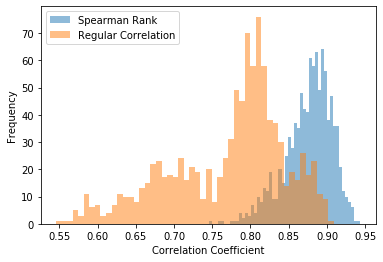

In [4]:
plt.hist(spearman_dist, bins=50, alpha=0.5)
plt.hist(correlation_dist, bins=50, alpha=0.5)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency');

现在让我们看看斯皮尔曼排名和常规系数如何应对当我们添加更多的噪音的情况。

Text(0, 0.5, 'Average Correlation Coefficient')

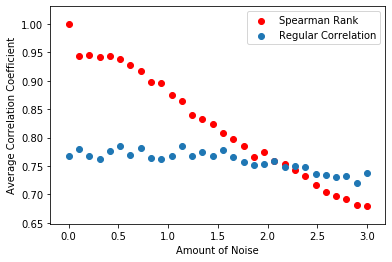

In [5]:
n = 100
noises = np.linspace(0, 3, 30)
experiments = 100
spearman = np.ndarray(len(noises))
correlation = np.ndarray(len(noises))

for i in range(len(noises)):
    # Run many experiments for each noise setting
    rank_coef = 0.0
    corr_coef = 0.0
    noise = noises[i]
    for j in range(experiments):
        r_s, c_c = compare_correlation_and_spearman_rank(n, noise)
        rank_coef += r_s
        corr_coef += c_c
    spearman[i] = rank_coef/experiments
    correlation[i] = corr_coef/experiments
    
plt.scatter(noises, spearman, color='r')
plt.scatter(noises, correlation)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel('Amount of Noise')
plt.ylabel('Average Correlation Coefficient')

我们可以看到，斯皮尔曼等级相关处理非线性关系在大多数水平的噪音更好。有趣的是，在非常高的水平，它似乎比正常的相关性做得更糟。

## 延迟相关

你可能会遇到这样的情况，一个过程会影响另一个过程，但影响会在一段时间后出现。现在让我们看看如果我们加上延迟会发生什么。

In [6]:
n = 100

X = np.random.rand(n)
Xrank = stats.rankdata(X, method='average')
# n-2 is the second to last element
Yrank = stats.rankdata([1,1] + list(X[:(n-2)]), method='average')

diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))
print (r_s)

-0.021641164116411593


当然，没有检测到这种关系。在使用常规和spearman相关性时，通过抵消数据和测试不同的偏移值来检查滞后关系是很重要的。

## 内置函数

我们也可以使用`scipy.stats`库中的`spearmanr`函数:

In [7]:
# Generate two random data sets
np.random.seed(161)
X = np.random.rand(10)
Y = np.random.rand(10)

r_s = stats.spearmanr(X, Y)
print('Spearman Rank Coefficient: ', r_s[0]) 
print( 'p-value: ', r_s[1])

Spearman Rank Coefficient:  0.23636363636363633
p-value:  0.5108853175152002


我们现在有一个$r_S$，但是我们如何解释它呢?它是正的，所以我们知道变量不是不相关的。它不是很大，所以我们知道它们不是完全正相关的，但很难一眼看出相关性有多重要。幸运的是，`spearmanr`也为我们计算了这个系数和样本量的p值。我们可以看到这里的p值大于0.05;因此，我们不能说$X$和$Y$是相关的。

## 现实世界的例子:共同基金费用比率

现在我们已经看到了Spearman的等级相关性是如何工作的，我们将很快地通过一些真实的数据再次经历这个过程。例如，我们可能想知道一个共同基金的费用比率是否反映了它的三年夏普比率。也就是说，花更多的钱在行政、管理等方面，是降低风险还是增加回报?Quantopian目前不支持共同基金，因此我们将从雅虎财经(Yahoo Finance)获取数据。我们的p值截止值通常默认为0.05。

### 数据源

感谢[马修马杜尔斯基](https://github.com/dursk)的数据。要获得相同的数据:

1. 从这个链接下载csv。https://gist.github.com/dursk/82eee65b7d1056b469ab
2. 把它上传到你的研究账户的“数据”文件夹。

Spearman Rank Coefficient:  -0.237573932355
p-value:  0.0167465097116


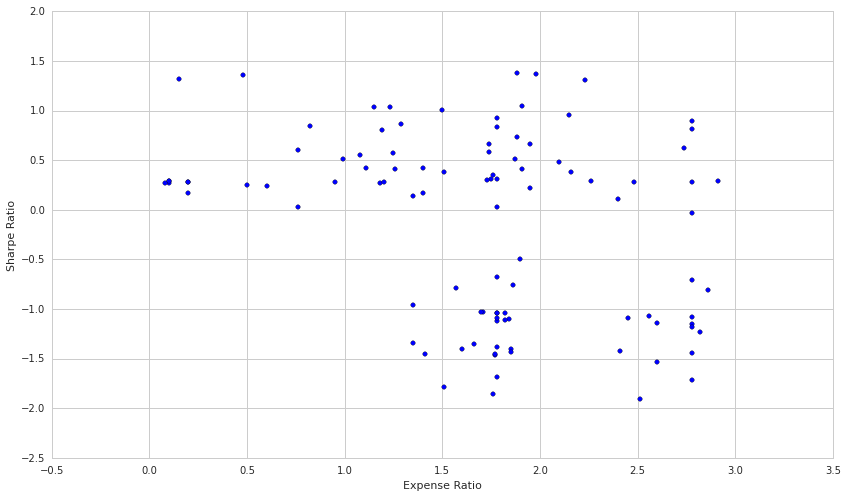

In [8]:
mutual_fund_data = local_csv('mutual_fund_data.csv')
expense = mutual_fund_data['Annual Expense Ratio'].values
sharpe = mutual_fund_data['Three Year Sharpe Ratio'].values

plt.scatter(expense, sharpe)
plt.xlabel('Expense Ratio')
plt.ylabel('Sharpe Ratio')

r_S = stats.spearmanr(expense, sharpe)
print('Spearman Rank Coefficient: ', r_S[0]) 
print ('p-value: ', r_S[1])

我们的p值低于临界值，这意味着我们接受这两个值是相关的假设。负相关系数表明存在负相关关系，价格越高的共同基金夏普比率越低。但是数据中出现了一些奇怪的聚类现象，似乎有一些夏普比率较低的高成本群体，主要是夏普比率与费用无关的群体。需要进一步的分析来理解这里发生了什么。

## 真实世界用例:评估一个排名模型

注意:[因素分析](https://www.quantopian.com/lectures/factor-analysis)现在更详细地讨论了这个主题

假设我们有一种对证券进行排名的方法，我们想要测试我们的排名在实践中的表现。在这种情况下，我们的模型只取最后一个月的平均日收益率，并根据该指标对股票进行排序。

我们假设这可以预测下个月的平均回报。为了测试这一点，我们基于一个回溯窗口对股票进行评分，然后采用斯皮尔曼等级相关性的得分和平均回报在步行前进一个月。

D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'AAC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'AAV', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'AAVL', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ABAC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ABCW', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ABGB', replacing with

Our Scores

Symbols
A      -0.000635
AA     -0.003676
AAL     0.005676
AAMC   -0.019971
AAME    0.002202
AAN     0.003732
AAOI    0.004623
AAON    0.004212
AAP     0.003873
AAPL   -0.001875
AAT     0.001454
AAU    -0.004052
AAWW    0.005025
AB     -0.000934
ABAX    0.000675
ABB    -0.002131
ABBV   -0.002466
ABC    -0.000318
ABCB    0.002164
ABCD   -0.000790
ABCO   -0.000838
ABDC   -0.001512
ABEV    0.000034
ABG     0.000803
AAC          NaN
AAV          NaN
AAVL         NaN
ABAC         NaN
ABCW         NaN
ABGB         NaN
dtype: float64




D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'AAWW', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'AB', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ABAX', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ABB', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ABBV', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
D:\Anaconda3\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ABC', replacing with N

The Walk Forward Returns

Symbols
A      -0.003876
AA     -0.000157
AAL    -0.003976
AAMC   -0.024877
AAME   -0.000392
AAN     0.001956
AAOI   -0.010894
AAON   -0.001097
AAP     0.000016
AAPL    0.003255
AAT     0.005517
AAU     0.013087
ABCD    0.021815
ABCO    0.000934
ABDC    0.001462
ABEV    0.003031
ABG    -0.000936
AAC          NaN
AAV          NaN
AAVL         NaN
AAWW         NaN
AB           NaN
ABAC         NaN
ABAX         NaN
ABB          NaN
ABBV         NaN
ABC          NaN
ABCB         NaN
ABCW         NaN
ABGB         NaN
dtype: float64


Correlation Coefficient: nan
p-value: nan


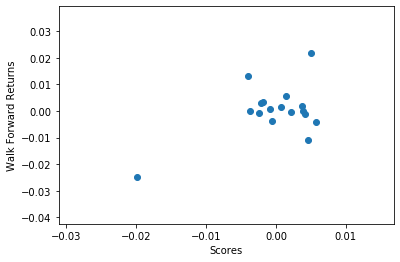

In [8]:
from pandas_datareader import data
symbol_list = ['A', 'AA', 'AAC', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAU', 'AAV', 'AAVL', 'AAWW', 'AB', 'ABAC', 'ABAX', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABCO', 'ABCW', 'ABDC', 'ABEV', 'ABG', 'ABGB']

# Get the returns over the lookback window
start = '2014-12-01'
end = '2015-01-01'
historical_returns = data.get_data_yahoo(symbol_list, start, end)['Close'].pct_change()[1:]

# Compute our stock score
scores = np.mean(historical_returns)
print('Our Scores\n') 
print(scores) 
print('\n') 

start = '2015-01-01'
end = '2015-02-01'
walk_forward_returns =  data.get_data_yahoo(symbol_list, start, end)['Close'].pct_change()[1:]
walk_forward_returns = np.mean(walk_forward_returns)
print('The Walk Forward Returns\n') 
print(walk_forward_returns) 
print('\n') 

plt.scatter(scores, walk_forward_returns)
plt.xlabel('Scores')
plt.ylabel('Walk Forward Returns')

r_s = stats.spearmanr(scores, walk_forward_returns)
print('Correlation Coefficient: ' + str(r_s[0])) 
print('p-value: ' + str(r_s[1])) 

p值表明，我们的假设是错误的，我们接受零假设，我们的排名并不比随机好。这对构建多空股票投资组合所设计的任何排名系统都是一个很好的检验。